**NOTE: This notebook assumes that you have already set up a Google Analytics ID and secret. You should
do this on your own and use this notebook as a reference for the `googleanalytics` API calls.**

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
from tqdm import tqdm

import googleanalytics as ga
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5, style='white')
plt.ion()
%matplotlib inline

In [2]:
# Load stored ENV variables
clientid = os.environ['GOOGLE_ANALYTICS_MYBINDER_CLIENTID']
clientsecret = os.environ['GOOGLE_ANALYTICS_MYBINDER_CLIENTSECRET']

# Set up account connection
accounts = ga.authenticate(identity='mybinder-analytics', client_id=clientid, client_secret=clientsecret,
                           interactive=True, save=True)
binder = accounts[-1].webproperties[0].profile

In [3]:
# Set up the query params
pageviews = binder.core.query\
    .metrics('pageviews', 'unique pageviews', 'time on page', 'bounces', 'entrances', 'exits') \
    .dimensions('pagePath') \
    .sort('pageviews', descending=True)

# Pageviews aggregated by time

In [4]:
N_DAYS = 28
START_DATE = datetime.today() - timedelta(days=N_DAYS)
STOP_DATE = datetime.today()  
dates = pd.date_range(START_DATE.strftime('%D'), STOP_DATE.strftime('%D'))

In [5]:
data = []
for day in tqdm(dates):
    data += [(ii.date, ii.page_path, ii.pageviews, ii.unique_pageviews)
             for ii in pageviews.daily(start=day, days=1).rows]

# Convert to DataFrame and munge
daily = pd.DataFrame(data, columns=['date', 'url', 'pageviews', 'unique_pageviews'])

org, repo, orgrepo = [], [], []
for row in daily['url'].values:
    parts = row.split('/')
    if len(parts) > 2 and row.startswith('/v2/'):
        org.append(parts[3])
        repo.append(parts[4])
        continue
    org.append(None)
    repo.append(None)

# Create a joined column for easier plotting
def join_org_repo(row):
    if all(row[ii] is not None for ii in ['org', 'repo']):
        return '/'.join(row[['org', 'repo']].values)
    else:
        return None
daily['org'] = org
daily['repo'] = repo
daily['orgrepo'] = daily.apply(join_org_repo, axis=1)

100%|██████████| 29/29 [00:10<00:00,  2.72it/s]


# Pageviews aggregated over time

In [6]:
agg = daily.groupby(['orgrepo']).sum().reset_index().sort_values('pageviews', ascending=False)

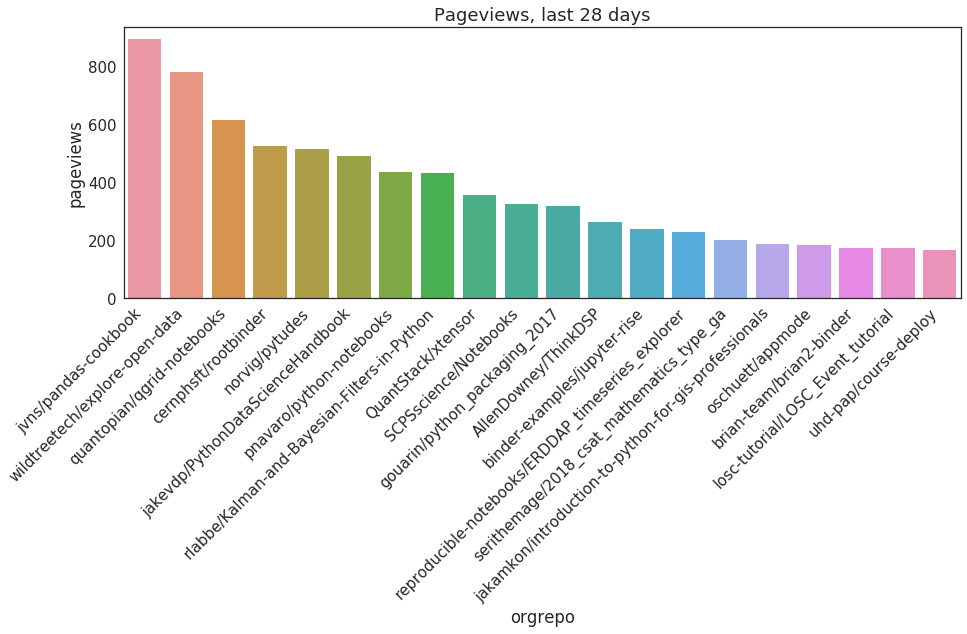

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.barplot('orgrepo', 'pageviews', data=agg.iloc[:20], ci=None)
ax.set(title="Pageviews, last {} days".format(N_DAYS))
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

# Repo builds over time

In [8]:
# Grab the ten biggest repos, plot these over time
N_REPOS = 7
repos = agg.iloc[:N_REPOS]['orgrepo'].values
plot_daily = daily.query('orgrepo in @repos')
plot_daily = plot_daily.groupby(['orgrepo', 'date']).sum().reset_index()

/home/choldgraf/anaconda/envs/dev/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


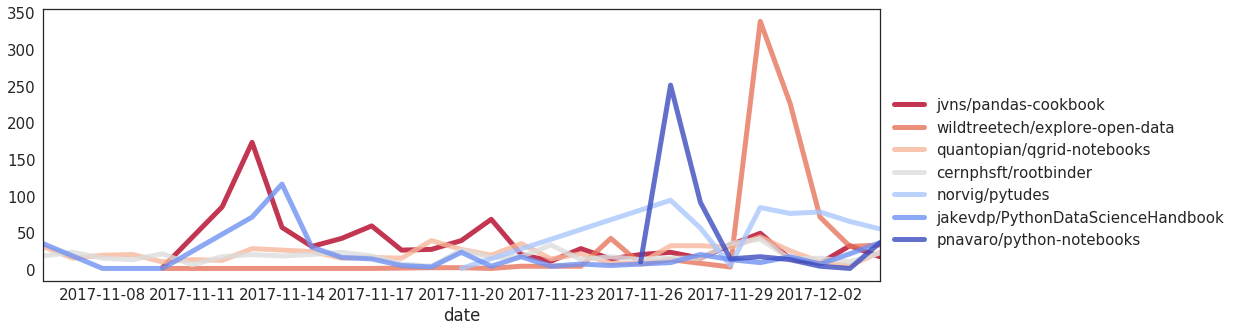

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_color_cycle(plt.cm.coolwarm_r(np.linspace(0, 1, N_REPOS)))
for repo in repos:
    i_data = plot_daily.query('orgrepo==@repo')
    i_data = i_data.sort_values('date')
    i_data.plot.line('date', 'pageviews', ax=ax, label=repo, lw=5, alpha=.8)
ax.legend(loc=(1.01, .1))